# FIT5202 - Data processing for Big Data


#### Assignment 2B: Using real-time streaming data to predict pedestrian traffic
- <strong>Student Name: Shizhen Wang</strong>
- <strong>Student Id: 2933995</strong>

### Architecture
(it is might be convenient for the interview)

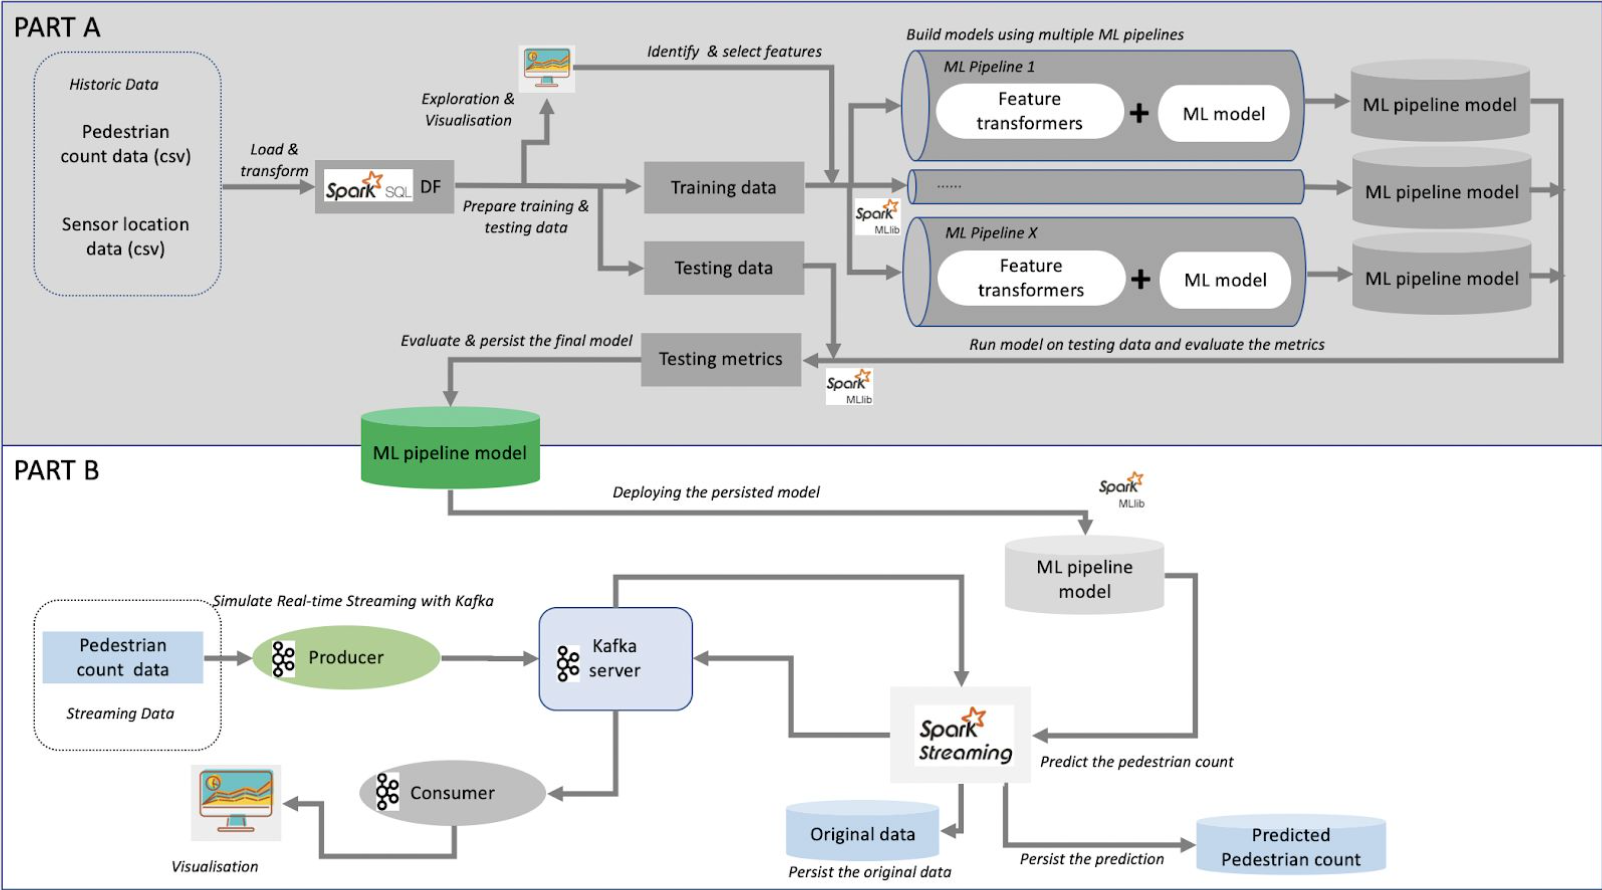

### 2. Streaming application using Spark Structured Streaming

In [1]:
# import statements
import os
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages org.apache.spark:spark-streaming-kafka-0-10_2.12:3.0.0,org.apache.spark:spark-sql-kafka-0-10_2.12:3.0.0 pyspark-shell'

from time import sleep
from json import dumps
from kafka import KafkaProducer
from pyspark import SparkConf
from pyspark import SparkContext
from pyspark.sql import SparkSession
from datetime import datetime
import pandas as pd
from pyspark.sql.types import *
from pyspark.ml import PipelineModel

#### 2.1 Write code to SparkSession is created using a SparkConf object, which would use two local cores with a proper application name, and use UTC as the timezone

In [2]:
# Create Spark Configuration Object
master = "local[2]"
app_name = "streaming_data_pedestrian_traffic"
spark_conf = SparkConf().setMaster(master).setAppName(app_name)

# create SparkSession
spark = SparkSession.builder.config(conf = spark_conf).getOrCreate()
sc = spark.sparkContext
sc.setLogLevel("ERROR")

# to use UTC as the session timezone
spark.conf.set("spark.sql.session.timeZone", "UTC")

#### 2.2 Write code to define the data schema for the sensor location CSV file, following the data types suggested in the metadata file1, with the exception of the “location” columns; then load the CSV file into a dataframe using the schema.

In [3]:
# define the data schema for the sensor location CSV file,
sensor_locations_schema = StructType()\
.add("sensor_id", IntegerType())\
.add("sensor_description", StringType())\
.add("sensor_name", StringType())\
.add("installation_date", DateType())\
.add("status", StringType())\
.add("note", StringType())\
.add("direction_1", StringType())\
.add("direction_2", StringType())\
.add("latitude", DoubleType())\
.add("longitude", DoubleType())\
.add("location", StringType())

In [4]:
#load the CSV file into a dataframe using the schema.

df_sensor_locations = spark.read.csv('Pedestrian_Counting_System_-_Sensor_Locations.csv',\
            header=True,\
            schema = sensor_locations_schema,\
            dateFormat = 'yyyy/MM/dd')

In [5]:
df_sensor_locations.show(1)

+---------+------------------+-----------+-----------------+------+----+-----------+-----------+------------+------------+--------------------+
|sensor_id|sensor_description|sensor_name|installation_date|status|note|direction_1|direction_2|    latitude|   longitude|            location|
+---------+------------------+-----------+-----------------+------+----+-----------+-----------+------------+------------+--------------------+
|       59|  Building 80 RMIT|     RMIT_T|       2019-02-13|     A|null|      North|      South|-37.80825648|144.96304859|(-37.80825648, 14...|
+---------+------------------+-----------+-----------------+------+----+-----------+-----------+------------+------------+--------------------+
only showing top 1 row



#### 2.3 Using the same topic name from the Kafka producers in Task 1, ingest the streaming data into Spark Streaming assuming all data coming in String format

In [5]:
topic = "pedestrian_traffic_c"

df = spark.readStream\
    .format("kafka")\
    .option("kafka.bootstrap.servers", "127.0.0.1:9092")\
    .option("subscribe", topic)\
    .load()

In [6]:
df.printSchema()

root
 |-- key: binary (nullable = true)
 |-- value: binary (nullable = true)
 |-- topic: string (nullable = true)
 |-- partition: integer (nullable = true)
 |-- offset: long (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- timestampType: integer (nullable = true)



In [7]:
# Converting the key/value from the kafka data stream to string
df = df.selectExpr("CAST(key AS STRING)", "CAST(value AS STRING)")

#### 2.4 Persist the raw streaming data in parquet format

In [9]:
# for debug by memory format.
query1 = df.writeStream\
        .outputMode("append")\
        .format("memory")\
        .queryName("query_memory_streaming")\
        .trigger(processingTime = '5 seconds')\
        .start()

In [10]:
while True: 
    spark.sql("select * from query_memory_streaming").show( truncate = False)
    sleep(5)

+---+-----+
|key|value|
+---+-----+
+---+-----+

+----+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|key |value                                                                                                                                                                                                                        |
+----+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|null|{"ID": 3438234, "Date_Time": "12/03/2020 02:00:00 AM", "Year": 2020, "Month": "December", "Mdate": 3, "Day": "Thursday", "Time": 2, "Sensor_ID": 39, "Sensor_Name": "Alfred Place", "Hourly_Counts": 2}                      |
|null|{"ID": 3438676, "Date_Time": 

KeyboardInterrupt: 

In [10]:
query1.stop()

In [65]:
# Persist the raw streaming data in parquet format
query2 =  df.writeStream\
          .format("parquet")\
          .outputMode("append")\
          .option("checkpointLocation", "parquet/dataStream_df/rawData")\
          .option("path", "parquet/dataStream_df")\
          .start()

In [34]:
# query2.stop()

#### 2.5 the streaming data format should be transformed into the proper formats following the metadata file schema, similar to assignment 2A.

In [8]:
# Converting the incoming stream into dataframe based on the schema
monthly_count_schema = StructType([
StructField("ID", IntegerType(), True),
StructField("Date_Time", TimestampType(), True),
StructField("Year", IntegerType(), True),
StructField("Month", StringType(), True),
StructField("Mdate", IntegerType(), True),
StructField("Day", StringType(), True),
StructField("Time", IntegerType(), True),
StructField("Sensor_ID", IntegerType(), True),
StructField("Sensor_Name", StringType(), True),
StructField("Hourly_Counts", IntegerType(), True)])

In [9]:
from pyspark.sql import functions as F
# Use from_json to parse the string to the json format based on the defined schema.
# from_json(col, schema, options={})[source] 
df_parsed = df.select(F.from_json(F.col("value").cast("string"), monthly_count_schema, 
                                 options = {'timestampFormat': 'MM/dd/yyyy hh:mm:ss a'})\
                    .alias('parsed_value'))\
                    .select(F.col("parsed_value.ID").alias("ID"),
                    F.col("parsed_value.Date_Time").alias("Date_Time"),
                    F.col("parsed_value.Year").alias("Year"),
                    F.col("parsed_value.Month").alias("Month"),
                    F.col("parsed_value.Mdate").alias("Mdate"),
                    F.col("parsed_value.Day").alias("Day"),
                    F.col("parsed_value.Time").alias("Time"),
                    F.col("parsed_value.Sensor_ID").alias("Sensor_ID"),
                    F.col("parsed_value.Sensor_Name").alias("Sensor_Name"),
                    F.col("parsed_value.Hourly_Counts").alias("Hourly_Counts")
)

In [10]:
df_parsed.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- Date_Time: timestamp (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Month: string (nullable = true)
 |-- Mdate: integer (nullable = true)
 |-- Day: string (nullable = true)
 |-- Time: integer (nullable = true)
 |-- Sensor_ID: integer (nullable = true)
 |-- Sensor_Name: string (nullable = true)
 |-- Hourly_Counts: integer (nullable = true)



In [12]:
# for debug~
query3 = df_parsed.writeStream\
        .outputMode("append")\
        .format("memory")\
        .queryName("query_formatted_data")\
        .trigger(processingTime = '5 seconds')\
        .start()
while True: 
    spark.sql("select * from query_formatted_data").show( truncate = False)
    sleep(5)

+---+---------+----+-----+-----+---+----+---------+-----------+-------------+
|ID |Date_Time|Year|Month|Mdate|Day|Time|Sensor_ID|Sensor_Name|Hourly_Counts|
+---+---------+----+-----+-----+---+----+---------+-----------+-------------+
+---+---------+----+-----+-----+---+----+---------+-----------+-------------+

+---+---------+----+-----+-----+---+----+---------+-----------+-------------+
|ID |Date_Time|Year|Month|Mdate|Day|Time|Sensor_ID|Sensor_Name|Hourly_Counts|
+---+---------+----+-----+-----+---+----+---------+-----------+-------------+
+---+---------+----+-----+-----+---+----+---------+-----------+-------------+

+-------+-------------------+----+--------+-----+---------+----+---------+---------------------------------+-------------+
|ID     |Date_Time          |Year|Month   |Mdate|Day      |Time|Sensor_ID|Sensor_Name                      |Hourly_Counts|
+-------+-------------------+----+--------+-----+---------+----+---------+---------------------------------+-------------+
|3437

KeyboardInterrupt: 

In [13]:
query3.stop()

#### 2.6 As the purpose of the recommendation is to predict the next day’s pedestrian count between 9am-11:59pm​, write code to perform the following transformations to prepare the columns for model prediction.

In [11]:
def debugFunc(df):
    i = 0
    query = df.writeStream\
        .outputMode("append")\
        .format("memory")\
        .queryName("query_formatted_data")\
        .trigger(processingTime = '5 seconds')\
        .start()
    while i < 2: 
        spark.sql("select * from query_formatted_data").show(truncate = False)
        sleep(5)
        i = i+1
    query.stop()
    return query

- ###### 2.6.a Create a date format column named “next_date” which represents the next calendar date of “Date_Time”

In [12]:
df_CreateA = df_parsed.withColumn('next_date', F.date_add(df_parsed.Date_Time, 1))

In [61]:
# debugFunc(df_CreateA).stop()

- ###### 2.6.b Create the column named “next_Mdate” based on the column “next_date” to include day of the month information

In [13]:
df_CreateB = df_CreateA.withColumn('next_Mdate', F.dayofmonth(df_CreateA.next_date))

In [60]:
# debugFunc(df_CreateB).stop()

- ###### 2.6.c Create the column named “next_day_week” based on the column “next_date” to include week of the year information

In [14]:
df_CreateC = df_CreateB.withColumn('next_day_week', F.weekofyear(df_CreateA.next_date))

In [59]:
# debugFunc(df_CreateC).stop()

- ###### 2.6.d Create the column named “next_day_of_week” based on the column “next_date” to include day of the week information, assuming Monday being the first day of week

In [15]:
# assuming Monday being the first day of week.
df_CreateD = df_CreateC.withColumn('next_day_of_week', F.dayofweek(df_CreateA.next_date))

In [16]:
from pyspark.sql.functions import when, col

df_CreateD = df_CreateC.withColumn("next_day_of_week", when(F.dayofweek(col("next_date")) == 1, 7)\
                    .otherwise(F.dayofweek(col("next_date")) -1))
# .cast(LongType))

- ###### 2.6.e Rename the column “Hourly_Count” as “prev_count”

In [20]:
df_CreateE = df_CreateD.withColumnRenamed('Hourly_Counts', 'prev_count')

In [33]:
debugFunc(df_CreateE).stop()
# i = 0
# query_CreateE = df_CreateE.writeStream\
#         .outputMode("append")\
#         .format("memory")\
#         .queryName("df_CreateE_data")\
#         .trigger(processingTime = '5 seconds')\
#         .start()
# while i <= 2: 
#         spark.sql("select * from df_CreateE_data").show(truncate = False)
#         sleep(5)
#         i += 1 
# query_CreateE.stop()

+---+---------+----+-----+-----+---+----+---------+-----------+----------+---------+----------+-------------+----------------+
|ID |Date_Time|Year|Month|Mdate|Day|Time|Sensor_ID|Sensor_Name|prev_count|next_date|next_Mdate|next_day_week|next_day_of_week|
+---+---------+----+-----+-----+---+----+---------+-----------+----------+---------+----------+-------------+----------------+
+---+---------+----+-----+-----+---+----+---------+-----------+----------+---------+----------+-------------+----------------+

+-------+-------------------+----+--------+-----+--------+----+---------+---------------------------------+----------+----------+----------+-------------+----------------+
|ID     |Date_Time          |Year|Month   |Mdate|Day     |Time|Sensor_ID|Sensor_Name                      |prev_count|next_date |next_Mdate|next_day_week|next_day_of_week|
+-------+-------------------+----+--------+-----+--------+----+---------+---------------------------------+----------+----------+----------+-------

In [62]:
# query_CreateE.stop()

#### 2.7 Load the machine learning models given, and use the model to predict the next day’s pedestrian count ​between 9am-11:59pm​. Persist the prediction result in parquet format.

In [17]:
pipeline = PipelineModel.load('./count_estimation_pipeline_model')

In [18]:
pipeline.stages

[VectorAssembler_f73ea57b794f,
 GBTRegressionModel: uid=GBTRegressor_f98f56e12d10, numTrees=20, numFeatures=6]

In [21]:
# predict the next day’s pedestrian count between 9am-11:59pm
predicted_count =  df_CreateE.filter(F.col('Time') >= 9)
predicted_count.columns

['ID',
 'Date_Time',
 'Year',
 'Month',
 'Mdate',
 'Day',
 'Time',
 'Sensor_ID',
 'Sensor_Name',
 'prev_count',
 'next_date',
 'next_Mdate',
 'next_day_week',
 'next_day_of_week']

In [22]:
prediction = pipeline.transform(predicted_count)

In [23]:
# dir(pipeline.params)
# pipeline.params.clear()
prediction

DataFrame[ID: int, Date_Time: timestamp, Year: int, Month: string, Mdate: int, Day: string, Time: int, Sensor_ID: int, Sensor_Name: string, prev_count: int, next_date: date, next_Mdate: int, next_day_week: int, next_day_of_week: int, features: vector, prediction: double]

In [32]:
debugFunc(prediction).stop()
# i = 0
# query_predict = prediction.writeStream\
#         .outputMode("append")\
#         .format("memory")\
#         .queryName("prediction_data")\
#         .trigger(processingTime = '5 seconds')\
#         .start()
# while i <= 3: 
#         spark.sql("select * from prediction_data").show(truncate = False)
#         sleep(5)
#         i += 1 
# query_predict.stop()

+---+---------+----+-----+-----+---+----+---------+-----------+----------+---------+----------+-------------+----------------+--------+----------+
|ID |Date_Time|Year|Month|Mdate|Day|Time|Sensor_ID|Sensor_Name|prev_count|next_date|next_Mdate|next_day_week|next_day_of_week|features|prediction|
+---+---------+----+-----+-----+---+----+---------+-----------+----------+---------+----------+-------------+----------------+--------+----------+
+---+---------+----+-----+-----+---+----+---------+-----------+----------+---------+----------+-------------+----------------+--------+----------+

+---+---------+----+-----+-----+---+----+---------+-----------+----------+---------+----------+-------------+----------------+--------+----------+
|ID |Date_Time|Year|Month|Mdate|Day|Time|Sensor_ID|Sensor_Name|prev_count|next_date|next_Mdate|next_day_week|next_day_of_week|features|prediction|
+---+---------+----+-----+-----+---+----+---------+-----------+----------+---------+----------+-------------+--------

In [45]:
# query_predict.stop()

In [34]:
# Persist the prediction result in parquet format
query4 =  prediction.writeStream\
          .format("parquet")\
          .outputMode("append")\
          .option("checkpointLocation", "parquet/dataStream_df/prediction")\
          .option("path", "parquet/dataStream_df")\
          .start()

In [48]:
# query4.stop()

#### 2.8 Using the prediction result, and write code to process the data following the requirements below 

- #### a. For each sensor, get the number of hours that the predicted pedestrian count would exceed 2000 on each day (for the hours between 9am-11:59pm). Show them inside the notebook file.

In [38]:
exceeded_count = prediction.filter(F.col('prediction') >= 2000)\
                .groupBy(prediction.Sensor_ID, F.window(prediction.Date_Time, '1 day'))\
                .count()

In [39]:
exceeded_count

DataFrame[Sensor_ID: int, window: struct<start:timestamp,end:timestamp>, count: bigint]

In [40]:
query5 = exceeded_count.writeStream\
        .outputMode("complete")\
        .format("memory")\
        .queryName("Exceeded_predicted_data")\
        .trigger(processingTime = '5 seconds')\
        .start()
while True: 
    spark.sql("select * from Exceeded_predicted_data").show(truncate = False)
    sleep(5)

+---------+------+-----+
|Sensor_ID|window|count|
+---------+------+-----+
+---------+------+-----+

+---------+------+-----+
|Sensor_ID|window|count|
+---------+------+-----+
+---------+------+-----+

+---------+------------------------------------------+-----+
|Sensor_ID|window                                    |count|
+---------+------------------------------------------+-----+
|4        |[2020-12-16 00:00:00, 2020-12-17 00:00:00]|8    |
|41       |[2020-12-16 00:00:00, 2020-12-17 00:00:00]|10   |
|68       |[2020-12-16 00:00:00, 2020-12-17 00:00:00]|4    |
|24       |[2020-12-16 00:00:00, 2020-12-17 00:00:00]|1    |
|1        |[2020-12-16 00:00:00, 2020-12-17 00:00:00]|6    |
|5        |[2020-12-16 00:00:00, 2020-12-17 00:00:00]|1    |
|22       |[2020-12-16 00:00:00, 2020-12-17 00:00:00]|3    |
|69       |[2020-12-16 00:00:00, 2020-12-17 00:00:00]|2    |
|6        |[2020-12-16 00:00:00, 2020-12-17 00:00:00]|2    |
|2        |[2020-12-16 00:00:00, 2020-12-17 00:00:00]|5    |
+----

KeyboardInterrupt: 

In [41]:
query5.stop()

- #### b. If any sensor’s hourly count between 9am-11:59pm on the next day is predicted to exceed 2000, combine the result with sensor longitude and latitude information, and write the stream back to Kafka sink using a different topic name

In [42]:
df_sensor_locations.columns

['sensor_id',
 'sensor_description',
 'sensor_name',
 'installation_date',
 'status',
 'note',
 'direction_1',
 'direction_2',
 'latitude',
 'longitude',
 'location']

In [43]:
sensor_query = exceeded_count.join(df_sensor_locations, 
                                   df_sensor_locations.sensor_id==exceeded_count.Sensor_ID,how='inner')\
                                .withColumn('count', F.col('count').cast(StringType()))\
                                .drop(exceeded_count.Sensor_ID)

In [44]:
sensor_query.dtypes

[('window', 'struct<start:timestamp,end:timestamp>'),
 ('count', 'string'),
 ('sensor_id', 'int'),
 ('sensor_description', 'string'),
 ('sensor_name', 'string'),
 ('installation_date', 'date'),
 ('status', 'string'),
 ('note', 'string'),
 ('direction_1', 'string'),
 ('direction_2', 'string'),
 ('latitude', 'double'),
 ('longitude', 'double'),
 ('location', 'string')]

In [45]:
# sensor_query_f = sensor_query.withColumn('window_end', F.col('window').end)\
#                             .withColumn('window_start', F.col('window').start)\
#                             .select('sensor_id','latitude','longitude', 'window_start', 'window_end', 'count')
sensor_query_f = sensor_query.select('sensor_id','count','status','latitude','longitude')

In [46]:
New_column = F.to_json(F.struct(sensor_query_f.columns))
# New_column
sensor_query_f2 = sensor_query_f.withColumn('key', F.current_timestamp())\
                            .withColumn('value', New_column)\
                            .select(F.col('value').cast('String'),F.col('key').cast('String'))

In [47]:
query6 = sensor_query_f2.writeStream\
        .outputMode("complete")\
        .format("memory")\
        .queryName("sensor_query_dt")\
        .trigger(processingTime = '5 seconds')\
        .start()
while True: 
    spark.sql("select * from sensor_query_dt").show(truncate = False)
    sleep(5)

+-----+---+
|value|key|
+-----+---+
+-----+---+

+-----+---+
|value|key|
+-----+---+
+-----+---+

+------------------------------------------------------------------------------------------+-----------------------+
|value                                                                                     |key                    |
+------------------------------------------------------------------------------------------+-----------------------+
|{"sensor_id":65,"count":"2","status":"A","latitude":-37.81569416,"longitude":144.96680641}|2021-02-10 09:02:37.049|
|{"sensor_id":35,"count":"2","status":"A","latitude":-37.82017828,"longitude":144.96508877}|2021-02-10 09:02:37.049|
|{"sensor_id":1,"count":"6","status":"A","latitude":-37.8134944,"longitude":144.96515324}  |2021-02-10 09:02:37.049|
|{"sensor_id":5,"count":"2","status":"A","latitude":-37.81874249,"longitude":144.96787656} |2021-02-10 09:02:37.049|
|{"sensor_id":61,"count":"5","status":"A","latitude":-37.80767455,"longitude":144.9

KeyboardInterrupt: 

In [52]:
query6.stop()

In [49]:
# write the stream back to Kafka sink 
kafka_query = sensor_query_f2.writeStream\
                    .format("kafka") \
                    .outputMode('update')\
                    .option("kafka.bootstrap.servers", "127.0.0.1:9092") \
                    .option("topic", "Kafka_stream_sensor")\
                    .trigger(processingTime = '5 seconds')\
                    .option('checkpointLocation', 'kafka_checkpoint_dt')\
                    .start()

In [51]:
kafka_query.stop()